In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np

# Build a function to compute error

In [2]:
def factory(sigma_square, has_conv_win, conv_win_size):
    def get_kernel(x, e):
        sigma = np.sqrt(sigma_square)
        mu = np.log(e) - sigma_square / 2
        result = (
                np.divide(1, x, where=x != 0)
                * sigma * np.sqrt(2 * np.pi)
                * np.exp(
            - ((np.log(x, where=x != 0) - mu) ** 2
               / (2 * sigma ** 2))
        )
        )
        result[0] = 0
        result_sum = np.sum(result)
        if result_sum != 0:
            result /= result_sum
        return result

    def convolve(target, kernel, pos):
        if not has_conv_win:
            return np.convolve(target, kernel)[:len(target)]
        # avoid overflow
        left = max(0, pos - conv_win_size)
        right = min(pos + conv_win_size, len(target))
        result = np.zeros(len(target))
        target_w = target[left:right]
        kernel_w = kernel[:2 * conv_win_size]
        result_w = np.convolve(target_w, kernel_w)
        result_w = result_w[:right - left]  # slice to window size
        result[left:right] = result_w
        result_sum = np.sum(result)
        if result_sum != 0:
            result /= result_sum
        return result

    def get_expectation(x, y):
        return np.dot(x, y)

    return get_kernel, convolve, get_expectation

def test1(axis_resolution, push_interval, nb_iterations, sigma_square, has_conv_win, conv_win_size, time_length, is_verbose):
    # iterate to convolve
    get_kernel, convolve, get_expectation = factory(sigma_square, has_conv_win, conv_win_size)
    x_axis = np.arange(0, time_length, axis_resolution)
    y_axis = np.zeros(len(x_axis))
    y_axis[0] = 1
    position = 0
    pusher = get_kernel(x_axis, push_interval)
    expectation_pusher = get_expectation(x_axis, pusher)
    if is_verbose:
        print('plotting conv kernel...')
        print('\t theoretical E: %.8f' % push_interval)
        print('\t actual E: %.8f' % expectation_pusher)
        print('\t ΔE: %.8f' % (expectation_pusher - push_interval))
        plt.title('conv kernel')
        plt.plot(x_axis, pusher)
        plt.vlines(expectation_pusher, 0, np.max(pusher), colors='red')
        plt.xlim([0, push_interval * 4])
        plt.show()
    expectation_y_axis = get_expectation(x_axis, y_axis)
    for i in range(nb_iterations):
        y_axis = convolve(y_axis, pusher, round(expectation_y_axis / axis_resolution))
        expectation_y_axis = get_expectation(x_axis, y_axis)
        if is_verbose:
            print('plotting prob after #%d iter...' % (i + 1))
            print('\t theoretical E: %.8f' % ((i + 1) * push_interval))
            print('\t actual E: %.8f' % expectation_y_axis)
            print('\t ΔE: %.8f' % (expectation_y_axis - (i + 1) * push_interval))
            plt.title(r'probability after #%d iteration' % (i + 1))
            plt.plot(x_axis, y_axis)
            plt.vlines(expectation_y_axis, 0, np.max(y_axis), colors='red')
            plt.xlim([expectation_y_axis - push_interval * 2, expectation_y_axis + push_interval * 2])
            plt.show()
    if is_verbose:
        print('after %d iterations, ΔE: %.8f' % (
                nb_iterations, expectation_y_axis - nb_iterations * push_interval)
             )
    return expectation_y_axis - nb_iterations * push_interval

Simply test it...

plotting conv kernel...
	 theoretical E: 0.04643991
	 actual E: 0.04643991
	 ΔE: -0.00000000


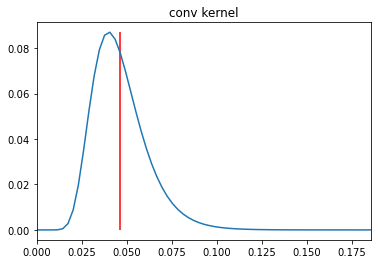

plotting prob after #1 iter...
	 theoretical E: 0.04643991
	 actual E: 0.04643991
	 ΔE: -0.00000000


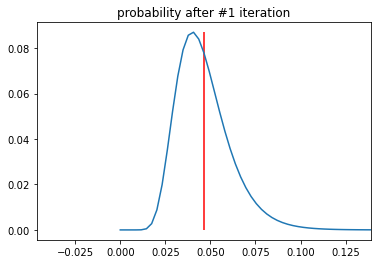

after 1 iterations, ΔE: -0.00000000


-4.876862802483117e-13

In [10]:
test1(axis_resolution=128/44100,
      push_interval=2048/44100,
      nb_iterations=1,
      sigma_square=0.1,
      has_conv_win=False,
      conv_win_size=0,
      time_length=10,
      is_verbose=True)

# Test with $\sigma$ and $resolution$

## Qualitative Analysis

The $resolution$ determines the how fine-grained the graph is when it is plotted. The smaller the $resolution$ is, the more fine-grained the graph is; and vice versa.

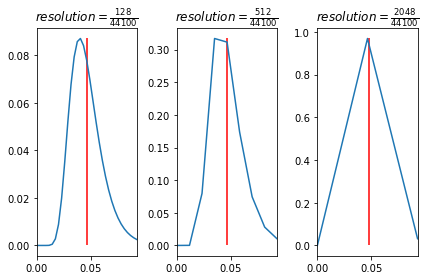

In [11]:
resolution_list = [128/44100, 512/44100, 2048/44100]
x_axis_list = []
kernel_list = []
expectation_list = []

push_interval = 2048/44100
for resolution in resolution_list:
    x_axis = np.arange(0, 5, resolution)
    get_kernel, _, get_expectation = factory(0.1, False, 0)
    kernel = get_kernel(x_axis, push_interval)
    x_axis_list.append(x_axis)
    kernel_list.append(kernel)
    expectation_list.append(get_expectation(x_axis, kernel))
for i in range(len(resolution_list)):
    plt.subplot(1, len(resolution_list), i + 1)
    plt.title(r'$resolution=\frac{%d}{44100}$' % (resolution_list[i] * 44100))
    plt.plot(x_axis_list[i], kernel_list[i])
    plt.vlines(expectation_list[i], 0, np.max(kernel_list[i]), 'r')
    plt.xlim([0, 2 * push_interval])
plt.tight_layout()
plt.show()

The $\sigma$ determines the how biased the graph is. The larger the $\sigma$, the more biased the graph is; and vice versa.

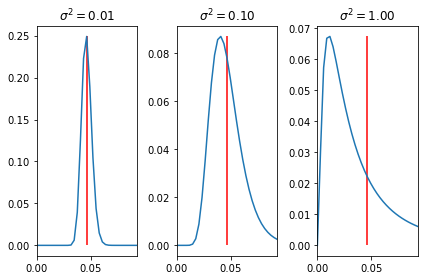

In [13]:
def plot1(sigma_square_list, x_axis):
    kernel_list = []
    expectation_list = []
    push_interval = 2048/44100
    for sigma_square in sigma_square_list:
        get_kernel, _, get_expectation = factory(sigma_square, False, 0)
        kernel = get_kernel(x_axis, push_interval)
        kernel_list.append(kernel)
        expectation_list.append(get_expectation(x_axis, kernel))
    for i in range(len(sigma_square_list)):
        plt.subplot(1, len(sigma_square_list), i + 1)
        plt.title(r'$\sigma^2=%.2f$' % sigma_square_list[i])
        plt.plot(x_axis, kernel_list[i])
        plt.vlines(expectation_list[i], 0, np.max(kernel_list[i]), 'r')
        plt.xlim([0, 2 * push_interval])
    plt.tight_layout()
    plt.show()

plot1(sigma_square_list = [0.01, 0.1, 1],
      x_axis = np.arange(0, 5, 128/44100))

## Rough Experiment

We first do a rough search of $\sigma$ and $resolution$.

Use the previous function to see how error changes with different $\sigma$ and $resolution$.

To avoid introducing other variables, we **do not** use window in convolution.

However, this will significantly increase computation time. The longer the X-axis, the more time needed for computation; and if the X-axis is too short, the tail is truncated, which will affect the expectation. Therefore, the length of the X-axis should be adequate.

estimated to push to: 2.32199546 sec
x-axis length: 10.00000000 sec
estimated percentage of x-axis to push to: 23.219955%


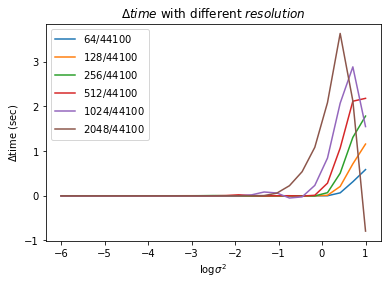

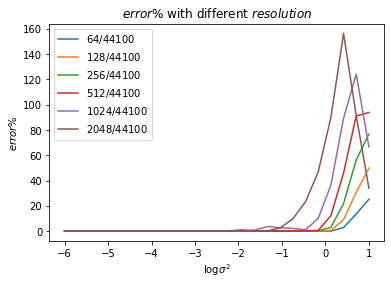

In [14]:
def plot2(log_sigma_square_list, resolution_list):
    iters = 50
    push_interval = 2048/44100
    time_length = 10
    print('estimated to push to: %.8f sec' % (iters * push_interval))
    print('x-axis length: %.8f sec' % time_length)
    print('estimated percentage of x-axis to push to: %.6f%%' % (iters * push_interval / time_length * 100))
    delta_time_list_list = []
    for i in range(len(resolution_list)):
        delta_time_list = [
            test1(axis_resolution=resolution_list[i],
                push_interval=push_interval,
                nb_iterations=iters,
                sigma_square=10 ** log_sigma_square,
                has_conv_win=False,
                conv_win_size=0,
                time_length=time_length,
                is_verbose=False)
            for log_sigma_square in log_sigma_square_list
        ]
        delta_time_list_list.append(delta_time_list)
        plt.plot(log_sigma_square_list, delta_time_list, label=r'$%d/44100$' % (resolution_list[i] * 44100))
    plt.legend()
    plt.title(r'$\Delta time$ with different $resolution$')
    plt.xlabel(r'$\log\sigma^2$')
    plt.ylabel(r'$\Delta$time (sec)')
    plt.show()
    for i in range(len(delta_time_list_list)):
        error_list = [
            abs(delta_time) / (iters * push_interval) * 100
            for delta_time in delta_time_list_list[i]
        ]
        plt.plot(log_sigma_square_list, error_list, label=r'$%d/44100$'% (resolution_list[i] * 44100))
    plt.legend()
    plt.title(r'$error\%$ with different $resolution$')
    plt.xlabel(r'$\log\sigma^2$')
    plt.ylabel(r'$error\%$')
    plt.show()

plot2(log_sigma_square_list=np.linspace(-6, 1, 25),
      resolution_list=np.array([64/44100, 128/44100, 256/44100, 512/44100, 1024/44100, 2048/44100]))

## Hypothetical Guess

As can be seen from these graphs, as the $\log{\sigma^2}$ increases, the error increases. The $\Delta time$ is usually positive, meaning that it pushes forward too quickly. And the less fine-grained the graph is (the larger $resolution$ is), the earlier the error rate starts to rise.

It is possibly because when $\log{\sigma^2}$ is larger, the peak of the convolution kernel moves more to the left. As it gets closer to zero, the peak may get hidden between the *first point* and the *second point* of the graph, which makes the peak moves to the right than it should be. Thus, the peak of the final result also moves to the right than it should be, in other words, it pushes too fast. And when the $resolution$ is larger, such situation starts to occur with smaller $\sigma$.

## Validation of the Guess

Let's validate this guess by plotting the convolution kernel with different $\sigma$ and a high $resolution$.

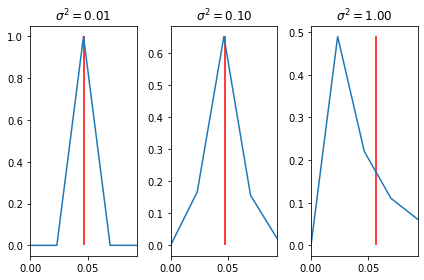

In [15]:
plot1(sigma_square_list = [0.01, 0.1, 1],
      x_axis = np.arange(0, 5, 1024/44100))

As can be seen from the graphs above, when the $resolution$ is relatively large, increasing $\sigma$ has no obvious effect at first. But as it increases to an certain extent, the expectation moves to the right.

To explain it, though the $resolution$ is large, and the true peak might be hidden between the *first point* and the *second point*, the correct expectation shows that some information is still preserved. However, when the $\sigma$ goes too large, the information is lost. And quite intuitively, the expectation moves to the right than it should be (the peak moves to the right due to low resolution), which means pushing too quickly.

## More Fine-grained Experiment

We then do a more accurate search of $\sigma$ and $resolution$.

estimated to push to: 2.32199546 sec
x-axis length: 10.00000000 sec
estimated percentage of x-axis to push to: 23.219955%


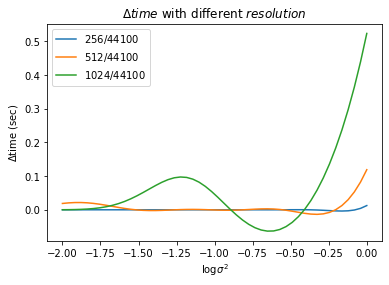

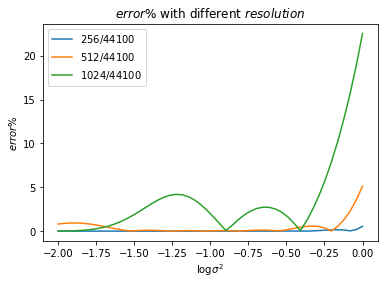

In [20]:
plot2(log_sigma_square_list=np.linspace(-2, 0, 50),
      resolution_list=np.array([256/44100, 512/44100, 1024/44100]))

For real-time system, too small $resolution$ leads to performance issue. Therefore, we cannot infinitely reduce $resolution$. We only need to find a $resolution$ that keeps a balance between performance and precision, and a range of $\sigma$ that minimizes the error rate to an acceptable range under this $resolution$.

According to the graph above, $$resolution=\frac{512}{44100}\mbox{ and }\log_{10}{\sigma^2}<-0.5$$ seems to be a good solution.

In [27]:
val = math.pow(10, -0.5)
val

0.31622776601683794

So, we have $$\sigma^2<0.31622776601683794$$

## A Tricky Method for $\sigma$

In [29]:
1 / (math.pow(math.e, val) - 1) / (1024/44100)

115.78774370959506

So, we have $$d>115.78774370959506$$

plotting conv kernel...
	 theoretical E: 0.04643991
	 actual E: 0.04648672
	 ΔE: 0.00004681


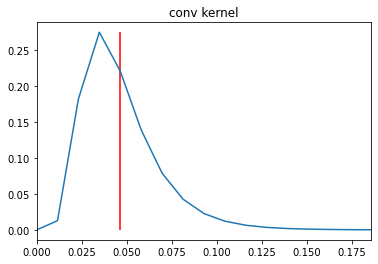

plotting prob after #1 iter...
	 theoretical E: 0.04643991
	 actual E: 0.04648672
	 ΔE: 0.00004681


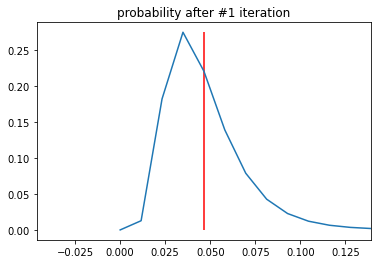

plotting prob after #2 iter...
	 theoretical E: 0.09287982
	 actual E: 0.09297344
	 ΔE: 0.00009362


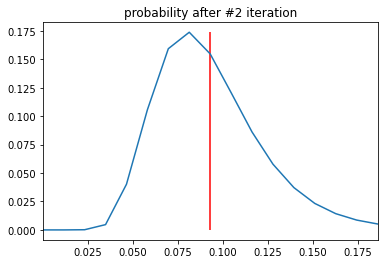

after 2 iterations, ΔE: 0.00009362


9.362009250521441e-05

In [25]:
d = 2048 / 44100
test1(axis_resolution=512/44100,
      push_interval=2048/44100,
      nb_iterations=2,
      sigma_square=math.log(1 / (100 * d) + 1),
      has_conv_win=False,
      conv_win_size=0,
      time_length=200,
      is_verbose=True)